In [1]:
import pyedflib

import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.signal import butter, filtfilt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from adan_pytorch import Adan

from os import listdir
import os

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from IPython.display import clear_output

# Loading and preprocess data

In [2]:
def ReadSignal(file_name): 

    f = pyedflib.EdfReader(file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((20, f.getNSamples()[0])) #or n
    
    if n == 22:
        for i in np.arange(19):
            sigbufs[i, :] = f.readSignal(i)
        sigbufs[19, :] = f.readSignal(21)
    elif n == 23:
        for i in np.arange(19):
            sigbufs[i, :] = f.readSignal(i)
        sigbufs[19, :] = f.readSignal(20)
    else:
        for i in np.arange(n):
            sigbufs[i, :] = f.readSignal(i)

    time = [1/f.samplefrequency(0) * i for i in range(len(sigbufs[0]))]

    annotations = f.readAnnotations()  


    new_annot = [(annotations[0][i], annotations[1][i], annotations[2][i])  
                 for i in range(len(annotations[0])) 
                                if (annotations[1][i] > 0) and (annotations[2][i] in ['?', 'Ð²Ñ\x81', 'Ð²Ñ\x81?'])]
    f.close()
    return sigbufs, new_annot, time, f.samplefrequency(0)

In [3]:
def broad_filter(signal, fs, lowcut=0.1, highcut=35):
    """Returns filtered signal sampled at fs Hz, with a [lowcut, highcut] Hz
    bandpass."""
    # Generate butter bandpass of order 3.
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, (low, high), btype='band')
    # Apply filter to the signal with zero-phase.
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [4]:
record_names = ["MoscowSpecialistsData/P2.edf", 
                "MoscowSpecialistsData/P3.edf", 
                "MoscowSpecialistsData/P4.edf", 
                "MoscowSpecialistsData/P5.edf", 
                "MoscowSpecialistsData/P6.edf", 
                "MoscowSpecialistsData/P8.edf"]

records = []
annots = []
times = []
freqs = []
for file_name in record_names:

    sigbufs, new_annot, time, freq = ReadSignal(file_name)
    records.append(broad_filter(sigbufs, 199))
    annots.append(new_annot)
    times.append(time)
    freqs.append(freq)
    

In [5]:
FREQ_EDF_WRITE = freqs[0]

In [6]:
def NormalizeAndClip(data):
    for i in tqdm(range(len(data))):
        signal = data[i]
        means = signal.mean(axis=1)[..., None]
        stds = signal.std(axis=1)[..., None]
        signal = np.clip((signal - means) / stds, a_min=-10, a_max=10)
        data[i] = signal

In [7]:
NormalizeAndClip(records)    

100%|███████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]


In [8]:
#PATH = "/home/gromov_n/MASS/ss2/"

In [9]:
# def ReadSignals(PATH):
#     all_data = {}
#     names = []
#     for file in tqdm(os.listdir(PATH)):
#         if "PSG" in file:
#             data = mne.io.read_raw_edf(PATH + file, verbose=False)
#             raw_data = data.get_data()
#             names = data.info.ch_names
#             labels = np.load("data/" + file + "labels.npy")
#             assert len(labels) == len(raw_data[0])
#             number = int(file[8:10])
#             all_data[number] = [raw_data, labels]
           
#             data.close()
#     return all_data, names

In [10]:
# all_data, names = ReadSignals(PATH)
# assert len(all_data) == 19

In [11]:
# IDS_INVALID = [4, 8, 15, 16]  # Only 1 expert 

In [12]:
# REF_ORDER = ['Fp1-F3',
#  'Fp2-F4',
#  'F3-C3',
#  'F4-C4',
#  'C3-P3',
#  'C4-P4',
#  'P3-O1',
#  'P4-O2',
#  'Fp1-F7',
#  'Fp2-F8',
#  'F7-T3',
#  'F8-T4',
#  'T3-T5',
#  'T4-T6',
#  'T5-O1',
#  'T6-O2',
#  'Fz-Cz',
#  'Cz-Pz',
#  'Fz-Pz',
#  'ECG']

In [13]:
# def RefToBibolarMontages(signals, lead_names_bip, lead_names_ref, ecg_idx):
#     new_signals = np.zeros_like(signals)[:20]
#     for row, name in enumerate(lead_names_bip):
#         first_lead, second_lead = name.split("-")
#         idx_first_lead, idx_second_lead = 0, 0
        
#         for i, ref_name in enumerate(lead_names_ref):
#             if ref_name.split("-")[0][4:] == first_lead:
#                 idx_first_lead = i
#             elif ref_name.split("-")[0][4:] == second_lead: # [4:]  start is EEG_
#                 idx_second_lead = i
        
#         new_signals[row] = signals[idx_first_lead] - signals[idx_second_lead]
#     new_signals[-1] = signals[ecg_idx]
#     return new_signals

In [14]:
# new_data_mass = []
# labels_mass = []
# times_mass = []
# annots_mass = []
# for i in range(len(all_data)):
#     if i + 1 not in IDS_INVALID:
#         new_data_mass.append(RefToBibolarMontages(all_data[i+1][0], REF_ORDER[:-1], names, -3))
#         labels_mass.append(all_data[i+1][1])
#         times_mass.append([1/256 * j for j in range(len(new_data_mass[-1][0]))])
#         annots_mass.append([[0], [times_mass[-1][-1]]])

In [15]:
def Labeling(time, events_lst):
    labels = np.zeros_like(time)

    for events in events_lst:
        for event in tqdm(events):
            start = np.array(time < event[0]).argmin()
            fin = np.array(time < event[0] + event[1]).argmin()
            labels[start:fin] =  1
    return labels
        

In [16]:
# all_labels = []
# for i in range(len(records)-2, len(records)):
#     labels = Labeling(times[i], [annots[i]])
#     if "Moscow" in record_names[i]:
#         np.save("MoscowSpecialistsData/Labels/" + record_names[i][22:] + "freq" + str(freqs[i])[:3], labels)
#     all_labels.append(labels)

In [17]:
all_labels = []

for i in range(len(records)):
    if "Moscow" in record_names[i]:
        all_labels.append(np.load("MoscowSpecialistsData/Labels/" + 
                                  record_names[i][22:] + "freq" + str(freqs[i])[:3] + ".npy"))

In [18]:
# records = new_data_mass + records
# annots = annots_mass + annots
# times = times_mass + times
# all_labels = labels_mass + all_labels

# Train Test Split

In [19]:
def Shuffle(records):
    shuffled_records = []
    for i in range(len(records)):
        shuffled_records.append(records[i].copy())
        np.random.shuffle(shuffled_records[-1][:-1])
    return shuffled_records

In [20]:
def GetTrainTestByIdxs(array, train_indices):
    train_array = [array[idx] for idx, is_train in enumerate(train_indices) if is_train == True]
    test_array = [array[idx] for idx, is_train in enumerate(train_indices) if is_train == False]    
    return train_array, test_array

def GetTrainTestSplit(records, annots, times, labels, index, shuffle_leads, N):
    train_indices = np.ones(N) #number of records
    
    train_indices[index] = 0
    
    train_records, test_records = GetTrainTestByIdxs(records, train_indices)
    train_labels, test_labels = GetTrainTestByIdxs(labels, train_indices)  
    train_annots, test_annots = GetTrainTestByIdxs(annots, train_indices)
    train_times, test_times = GetTrainTestByIdxs(times, train_indices)
    
    
    if shuffle_leads:
        train_records = Shuffle(train_records)
    
    train_data = []
    for i in range(len(train_records)):
        train_time_start = train_annots[i][0][0]
        train_time_end = train_annots[i][-1][0]
        train_idx_start = (np.array(train_times[i]) <= train_time_start).argmin()
        train_idx_fin = (np.array(train_times[i]) < train_time_end).argmin()        
        
        train_data.append(torch.FloatTensor(train_records[i][:, train_idx_start:train_idx_fin]))
        
        current_labels = train_labels[i][train_idx_start:train_idx_fin]
        new_trainl = torch.zeros(2, len(current_labels))
        new_trainl = (torch.arange(2) == torch.LongTensor(current_labels)[:,None]).T
        new_trainl = new_trainl.float()
        train_labels[i] = new_trainl
    
    test_data = []
    for i in range(len(test_records)):
        test_time_start = test_annots[i][0][0]
        test_time_end = test_annots[i][-1][0]
        test_idx_start = (np.array(test_times[i]) <= test_time_start).argmin()
        test_idx_fin = (np.array(test_times[i]) < test_time_end).argmin()

        test_data.append(torch.FloatTensor(test_records[i][:, test_idx_start:test_idx_fin]))
        
        current_labels = test_labels[i][test_idx_start:test_idx_fin]
        new_testl = torch.zeros(2, len(current_labels))
        new_testl = (torch.arange(2) == torch.LongTensor(current_labels)[:,None]).T
        new_testl = new_testl.float()
        test_labels[i] = new_testl
    
    return train_data, train_labels, test_data, test_labels

In [21]:
RECEPTIVE_FIELD = 4000
OVERLAP = 0 

def CreateSamples(x, labels, rf = RECEPTIVE_FIELD, ov = OVERLAP):
    inout_seq = []
    L = x.shape[-1]
    for i in tqdm(range(ov, L- rf - ov, rf)):
        train_seq = x[:, i-ov:i+rf+ov]
        train_label = labels[:, i:i+rf]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    

# Net and Training

In [22]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out       

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        
        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        
        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5, padding=8)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25, padding=8)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125, padding=8)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest') #for 4000 it is 5 and for 100 is 4
        
        self.outcov = nn.Conv1d(self.layer_n, 2, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        
        #print("x", x.size())
        pool_x1 = self.AvgPool1D1(x)
        #print("pool_x1", pool_x1.size())
        
        pool_x2 = self.AvgPool1D2(x)
        #print("pool_x2", pool_x2.size())
        
        pool_x3 = self.AvgPool1D3(x)
        #print("pool_x3", pool_x3.size())
        
        
        #############Encoder#####################
        
        out_0 = self.layer1(x)
        #print("out_0", out_0.size())
        out_1 = self.layer2(out_0)        
        #print("out_1", out_1.size())
        
        
        x = torch.cat([out_1,pool_x1],1)

        #print("x", x.size())
        out_2 = self.layer3(x)
        #print("out_2", out_2.size())
        
        x = torch.cat([out_2,pool_x2],1)
        #print("x", x.size())
        x = self.layer4(x)
        #print("x", x.size())
        
        
        #############Decoder####################
        
        up = self.upsample1(x)
        #print("up", up.size())
        
        up = torch.cat([up,out_2],1)
        #print("up", up.size())
        
        up = self.cbr_up1(up)
        #print("up", up.size())
        
        up = self.upsample(up)
        #print("up", up.size())
        
        up = torch.cat([up,out_1],1)
        #print("up", up.size())
        
        up = self.cbr_up2(up)
        #print("up", up.size())
        
        
        up = self.upsample(up)
        #print("up", up.size())
        
        up = torch.cat([up,out_0],1)
        #print("up", up.size())
        
        up = self.cbr_up3(up)
        #print("up", up.size())
        
        out = self.outcov(up)
        #print("out", out.size())
        
        #out = nn.functional.softmax(out,dim=2)
        
        return out

In [23]:
class MDB_block(nn.Module):
    def __init__(self, k, F):
        super(MDB_block, self).__init__()

        #print(F, k)
        self.conv11 = nn.Conv1d(F, F//2, kernel_size=k, dilation=1, padding=(k-1)//2) #p = d * (k-1) / 2
        self.bn11 = nn.BatchNorm1d(F//2)
        self.conv12 = nn.Conv1d(F, F//4, kernel_size=k, dilation=2, padding=k-1) 
        self.bn12 = nn.BatchNorm1d(F//4)
        self.conv13 = nn.Conv1d(F, F//8, kernel_size=k, dilation=4, padding=2*(k-1))
        self.bn13 = nn.BatchNorm1d(F//8)
        self.conv14 = nn.Conv1d(F, F//8, kernel_size=k, dilation=8, padding=4*(k-1))
        self.bn14 = nn.BatchNorm1d(F//8)

        self.conv21 = nn.Conv1d(F//2, F//2, kernel_size=k, dilation=1, padding=(k-1)//2)
        self.bn21 = nn.BatchNorm1d(F//2)
        self.conv22 = nn.Conv1d(F//4, F//4, kernel_size=k, dilation=2, padding=k-1)
        self.bn22 = nn.BatchNorm1d(F//4)
        self.conv23 = nn.Conv1d(F//8, F//8, kernel_size=k, dilation=4, padding=2*(k-1))
        self.bn23 = nn.BatchNorm1d(F//8)
        self.conv24 = nn.Conv1d(F//8, F//8, kernel_size=k, dilation=8, padding=4*(k-1))
        self.bn24 = nn.BatchNorm1d(F//8)

        self.relu = nn.ReLU()

        
    
    def forward(self,x):

        x1 = self.conv11(x)
        x1 = self.bn11(x1)
        x1 = self.relu(x1)
        x1 = self.conv21(x1)
        x1 = self.bn21(x1)
        x1 = self.relu(x1)
        
        x2 = self.conv12(x)
        x2 = self.bn12(x2)
        x2 = self.relu(x2)
        x2 = self.conv22(x2)
        x2 = self.bn22(x2)
        x2 = self.relu(x2)

        x3 = self.conv13(x)
        x3 = self.bn13(x3)
        x3 = self.relu(x3)
        x3 = self.conv23(x3)
        x3 = self.bn23(x3)
        x3 = self.relu(x3)

        x4 = self.conv14(x)
        x4 = self.bn14(x4)
        x4 = self.relu(x4)
        x4 = self.conv24(x4)
        x4 = self.bn24(x4)
        x4 = self.relu(x4)

        
        return torch.concatenate([x1, x2, x3, x4], axis=1)  

class SEED(nn.Module):
    def __init__(self, overlap=0, input_dim=27, F = 64, q1=0.2, q2=0.5, N1=256, N2=128):
        super(SEED, self).__init__()

        self.N1 = N1
        
        self.bn = nn.BatchNorm1d(input_dim)
        self.conv1 = nn.Conv1d(input_dim, F, kernel_size=3, padding = 520 - overlap)
        self.bn1 = nn.BatchNorm1d(F)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(F, 2*F, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2*F)

        self.AvgPool1D = nn.AvgPool1d(2)

        self.mdb1 = MDB_block(3, 2*F)

        self.conv3 = nn.Conv1d(2*F, 4*F, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(4*F)
        
        self.mdb2 = MDB_block(3, 4*F)

        self.dropout1 = nn.Dropout(q1)
        self.dropout2 = nn.Dropout(q2)

        
        self.lstm1 = nn.LSTM(N1, N1, num_layers=1, batch_first=True, bidirectional=True)
        self.convlstm1 = nn.Conv1d(2*N1, N1, kernel_size=1) #256?
        self.bn3 = nn.BatchNorm1d(N1)

        self.lstm2 = nn.LSTM(N1, N1, num_layers=1, batch_first=True, bidirectional=True)
        self.convlstm2 = nn.Conv1d(2*N1, N1, kernel_size=1) #256?
        self.bn4 = nn.BatchNorm1d(N1)

        self.classifier1 = nn.Conv1d(N1, N2, kernel_size=1) 
        self.bn5 = nn.BatchNorm1d(N2)
        self.classifier2 = nn.Conv1d(N2, 2, kernel_size=1) 

        self.upsample = nn.Upsample(scale_factor=8, mode='nearest')

    def forward(self,x):
        x = self.bn(x)
        x = self.conv1(x)
        
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        
        
        x = self.bn2(x)
        x = self.relu(x)

        x = self.AvgPool1D(x)
        
        
        x = self.mdb1(x)
        

        x = self.conv3(x)
        
        
        x = self.bn3(x)
        x = self.relu(x)

        x = self.AvgPool1D(x)
        
        
        x = self.mdb2(x)
        
        

        x = self.AvgPool1D(x)
        

        x = x[:, :, 65:-64]
        

        x = self.dropout1(x)

        lstm_out, (h_n, c_n) = self.lstm1(x.transpose(2, 1))

        

        x = lstm_out[:, :, :self.N1] + lstm_out[:, :, self.N1:]
        x = self.dropout2(x)

        

        lstm_out, (h_n, c_n) = self.lstm2(x)

        

        x = lstm_out[:, :, :self.N1] + lstm_out[:, :, self.N1:]
        x = self.dropout2(x)
        
        x = x.transpose(2, 1)
        x = self.dropout2(x)
        

        x = self.classifier1(x)
        
        
        x = self.bn5(x)
        x = self.relu(x)

        x = self.classifier2(x)    
        

        x =self.upsample(x)    
        
    
        return x
        
        
        

In [24]:
def run_epoch(model, optimizer, criterion, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in tqdm(enumerate(dataloader)):
        if is_training:
            optimizer.zero_grad()
      
        #print("x", x.shape)
        

        out = model(x.to('cuda'))
        #print("y", y.shape)
        #print("out", out.shape)
        loss = criterion(out, y.to('cuda'))

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

In [25]:
def GetRawMetricsAndCMEPINoLogging(predictions, test_labels):
    TP_sum = 0
    FP_sum = 0
    FN_sum = 0    
    
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])

        TP, FP, FN = CollectingTPFPFN(predictions[i], test_labels[i][1, :pred_len].numpy())

        TP_sum += TP
        FP_sum += FP
        FN_sum += FN      

        
    return 2 * TP_sum / (2 * TP_sum + FP_sum + FN_sum)
    

In [26]:
def CalculateMetric(model, test_dataloader, test_labels, split_index, model_name): # now only for 1 record in test_dataloader
    

    all_preds = []
    record_preds = []
    for idx, (x, y) in tqdm(enumerate(test_dataloader)):
        
      
        #print("x", x.shape)
        

        out = model(x.to('cuda'))
        
        m = nn.Softmax(dim=1)
        out = m(out)
            
        preds = np.argmax(out.detach().cpu().numpy(), axis=1)
        record_preds.append(preds)
    shapes = np.array(record_preds).shape
    record_preds = np.array(record_preds).reshape(shapes[0] * shapes[1] * shapes[2])
    all_preds.append(record_preds)
    
    threshold1 = 30
    threshold2 = None
    
    overlap=0
    if model_name == "SEED":
        overlap = 520
    
    for j in range(len(all_preds)):
        PostProcessing(all_preds[j], threshold1, threshold2)
    test_labels_overlap = [labels[:, overlap:] for labels in test_labels]
    metric = GetRawMetricsAndCMEPINoLogging(all_preds, test_labels_overlap)
    return metric

In [38]:
def Train(model, train_dataloader, test_dataloader, test_labels, i, path, model_name):

    criterion = nn.BCEWithLogitsLoss()#pos_weight = torch.FloatTensor([[0.3, 0.7]] * 4000).T.to("cuda"))
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
    scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor=0.5, min_lr=0.0001)
    epochs = 1000

    losses_train = []
    losses_test = []
    metrics = []
    best_loss = 10e9
    best_metric = 0
    
    # begin training

    early_stop_count = 15
    current_es = 0
    best_epoch = 0
    for epoch in range(epochs): 


        loss_train = run_epoch(model, optimizer, criterion, train_dataloader, is_training=True)
        loss_val = run_epoch(model, optimizer, criterion, test_dataloader)
        scheduler.step(loss_val)
        losses_train.append(loss_train)
        losses_test.append(loss_val)
        
        metric = CalculateMetric(model, test_dataloader, test_labels, i, model_name)
        metrics.append(metric)
        
        if metric >= best_metric:
            best_metric = metric
            torch.save(model.state_dict(), path + "/Split" + str(i) +"/" + model_name)
            best_epoch = epoch

#         if losses_test[-1] < best_loss:
#             current_es = 0
#             best_loss = losses_test[-1]
#             torch.save(model.state_dict(), path + "/Split" + str(i) +"/Unet1d")
#             best_epoch = epoch
#         else:
#             current_es += 1
        #if current_es == early_stop_count:
            #break

        clear_output(True)
        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(3, 1, 1)
        ax_2 = fig.add_subplot(3, 1, 2)
        ax_3 = fig.add_subplot(3, 1, 3)
        
        ax_1.set_title('train loss')
        ax_1.plot(losses_train)
        ax_2.set_title('test loss')
        ax_2.plot(losses_test)
        ax_3.set_title('test metric')
        ax_3.plot(metrics)
        plt.savefig(path + "/Split" + str(i) + "/"+ model_name + "Figure")

        plt.show()


        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
                  .format(epoch+1, epochs, loss_train, loss_val))
    f = open(path + "/Split" + str(i) + "/BestEpoch.txt", 'w')
    f.write(str(best_epoch))
    f.close()
    

# Collecting Predictions, Calculating Metrics

In [28]:
def CollectingPreds(model, test_data, model_name):

    model.eval()
    model.cpu()
    all_preds = []
    
    overlap = 0
    if model_name == "SEED":
        overlap=520
    for i in range(len(test_data)):
        record_preds = []
        
        for idx in tqdm(range(overlap, test_data[i].size()[1]- RECEPTIVE_FIELD - overlap, RECEPTIVE_FIELD)):

            train_seq = test_data[i][:, idx-overlap:idx+RECEPTIVE_FIELD+overlap][None, ...]
                  
            out = model(train_seq)
            m = nn.Softmax(dim=1)
            out = m(out)
            
            preds = np.argmax(out.detach().cpu().numpy(), axis=1)
            record_preds.append(preds)
        shapes = np.array(record_preds).shape
        record_preds = np.array(record_preds).reshape(shapes[0] * shapes[1] * shapes[2])
        all_preds.append(record_preds)
    return all_preds

In [29]:
def MergeClose(predictions, threshold):
    i = 0
    in_event = False
    while i < len(predictions):
        while i < len(predictions) and predictions[i] == 1:
            in_event = True
            i += 1
        if  i < len(predictions) and in_event:
            if np.any(predictions[i:i+threshold]):
                while  i < len(predictions) and predictions[i] == 0:
                    predictions[i] = 1
                    i += 1
            else:
                in_event = False
        i += 1

def DeleteShortEvents(predictions, threshold):
    i = 0
    while i < len(predictions):
        event_len = 0
        event_idx_start = i
        while i < len(predictions) and predictions[i] == 1:
            i += 1
            event_len += 1
        if event_len < threshold:
            predictions[event_idx_start:i] = 0
        i += 1
def PostProcessing(predictions, threshold1, threshold2=None):
    MergeClose(predictions, threshold1)
    if threshold2 is None:
        DeleteShortEvents(predictions, threshold1)
    else:
        DeleteShortEvents(predictions, threshold2)
        

In [30]:
def CollectingTPFPFN(pred_labels, true_labels):
    i = 0
    TP = 0
    FP = 0
    FN = 0

    is_true_flag = 0
    is_pred_flag = 0
    is_used_pred_flag = 0
    
    while i < len(pred_labels):
        if pred_labels[i] == 0:
            is_used_pred_flag = 0
        while i < len(pred_labels) and true_labels[i] == 1:
            is_true_flag = 1
            if not is_used_pred_flag:
                if pred_labels[i] == 1:
                    is_pred_flag = 1
                    is_used_pred_flag = 1 
            else:
                if pred_labels[i] == 0:
                    is_used_pred_flag = 0
            i += 1
        if is_true_flag:
            if is_pred_flag:
                TP += 1
            else:
                FN += 1
            i -= 1

        
        is_true_flag = 0
        is_pred_flag = 0   
        i += 1

    i = 0
    while i < len(pred_labels):
        while i < len(pred_labels) and pred_labels[i] == 1:
            is_pred_flag = 1
            if true_labels[i] == 1:
                is_true_flag = 1
            i += 1
        if is_pred_flag and not is_true_flag:
            FP += 1
        is_pred_flag = 0
        is_true_flag = 0
        i += 1

    return TP, FP, FN 

def GetRawMetricsAndCMEPI(predictions, test_labels, split_index, path, N):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []

    TP_sum = 0
    FP_sum = 0
    FN_sum = 0
    
    all_cm = 0
    
    train_indices = np.ones(N) #number of records
    
    train_indices[split_index] = 0
        
    train_record_names, test_record_names = GetTrainTestByIdxs(record_names, train_indices)
    
        
    f = open(path + "/Split" + str(split_index) + "/Metrics.txt", 'w')
    
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])

        TP, FP, FN = CollectingTPFPFN(predictions[i], test_labels[i][1, :pred_len].numpy())

        TP_sum += TP
        FP_sum += FP
        FN_sum += FN
            
        if TP + FP != 0:
            precision.append(TP / (TP + FP))
        else:
            precision.append(0)
        recall.append(TP / (TP + FN))
        f1.append(2 * TP / (2 * TP + FP + FN))
        

        cm = np.array([[0, FP], [FN, TP]])
        all_cm += cm
        
        f.write("=============Record " + test_record_names[i] + "================\n")
    
        f.write("precision " + str(precision[i]) + "\n")
        f.write("recall " + str(recall[i]) + "\n")
        f.write("f1 score " + str(f1[i]) + "\n")
                
        con_mat = ConfusionMatrixDisplay(cm)
        con_mat.plot().figure_.savefig(path + "/Split" + str(split_index) + 
                                "/ConfusionMatrix_" + test_record_names[i].replace("/", "_") + ".png")
    f.write("===========ALL RECORDS SCORE==================\n")
    
    if TP_sum + FP_sum != 0:
        f.write("Full precision " + str(TP_sum / (TP_sum + FP_sum)) + "\n")
    else:
        f.write("Full precision " + str(0) + "\n")
        
    f.write("Full recall " + str(TP_sum / (TP_sum + FN_sum)) + "\n")
    f.write("Full f1 " + str(2 * TP_sum / (2 * TP_sum + FP_sum + FN_sum)) + "\n")
    
    
    f.close()
    con_mat = ConfusionMatrixDisplay(all_cm)
    con_mat.plot().figure_.savefig(path + "/Split" + str(split_index) + 
                                "/ConfusionMatrixFull.png")

# Logging and Creating Folder

In [31]:
def LogResults(model, test_data, test_labels, i, path, last_epoch, low_freq, area_SWI, write_edf, annots, N, model_name):
    if not last_epoch:
        model.load_state_dict(torch.load(path + "/Split" + str(i) +"/" + model_name))  
    all_preds = CollectingPreds(model, test_data, model_name)
    threshold1 = 30 #25 low because of lower sample rate, for 500 need to up to ???
    threshold2 = None
    sr = 200
    if not low_freq:
        threshold = 30
        sr = 500
    for j in range(len(all_preds)):
        PostProcessing(all_preds[j], threshold1, threshold2)
        
    overlap = 0
    if model_name == "SEED":
        overlap = 520
    test_labels_overlap = [labels[:, overlap:] for labels in test_labels]
    
    GetRawMetricsAndCMEPI(all_preds, test_labels_overlap, i, path, N)  
    if write_edf:
        WriteEDF(all_preds, i, FREQ_EDF_WRITE, annots, path, N)
        
#     SWIs_pred = []
#     SWIs_true = []
    
#     for j in range(len(all_preds)):
#         SWIs_pred.append(CalculateSWI(all_preds[j], sr, area_SWI))
#         SWIs_true.append(CalculateSWI(test_labels[j][1], sr, area_SWI))     
#    np.savetxt(path + "/Split" + str(i) +"/SWIPred", np.array(SWIs_pred))
#    np.savetxt(path + "/Split" + str(i) +"/SWITrue", np.array(SWIs_true))    

In [32]:
def CreateFolder(path, N):
    try:  
        os.mkdir(path)  
    except OSError as error:
        True
    for i in range(N):
        try:
            os.mkdir(path + "/Split" + str(i))
        except OSError as error:
            continue
    

# EDF write

In [33]:
def CreateNewAnnotation(time_start, labels, freq): 
    freq = 1/freq
    i = 0
    label_starts = [time_start]
    label_lens = [-1]
    desc = ["StartPredictionTime"]
    while i < len(labels):
        if labels[i] == 1:
            desc.append("ModelPrediction")
            label_starts.append(time_start + i*freq)
            cur_start = i
            while labels[i] == 1:
                i += 1
            label_lens.append((i - cur_start) * freq)
        i += 1
    label_starts += [time_start + i*freq]
    label_lens += [-1]
    desc += ["EndPredictionTime"]

    return np.array(label_starts), np.array(label_lens), np.array(desc)

In [34]:
def WriteEDF(predictions, split_index, freq, annots, path, N):
    train_indices = np.ones(N) #number of records
    
    train_indices[split_index] = 0
        
    train_record_names, test_record_names = GetTrainTestByIdxs(record_names, train_indices)
#     train_indices = np.ones(19) #number of records
#     train_indices[-split_index] = 0   # mass
    train_annots, test_annots = GetTrainTestByIdxs(annots, train_indices)
    for i in range(len(test_record_names)):
        time_start = test_annots[i][0][0]
        print(time_start)
        preds_annotations = CreateNewAnnotation(time_start, predictions[i], freq)
        data = mne.io.read_raw_edf(test_record_names[i])

        preds_annotations = list(preds_annotations)
        preds_annotations[1] = np.clip(preds_annotations[1], a_min=0, a_max = None)
        print(np.isnan(preds_annotations[1]).any())

        old_annot = np.array([[data.annotations[i]["onset"], data.annotations[i]["duration"], data.annotations[i]["description"]] 
                      for i in range(len(data.annotations))])
        
        full_annot = np.concatenate([np.array(preds_annotations), old_annot.T], axis=1)
        annotations = mne.Annotations(np.array(full_annot)[0], np.array(full_annot)[1], np.array(full_annot)[2])
        print(annotations)
        data.set_annotations(annotations)
        
        data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
        data.close()
        

# Exps

In [35]:
def CrossValidationExperement(records, annots, times, labels, path, shuffle_leads=False, last_epoch=False, low_freq=True, 
                              is_train=True, area_SWI=False, write_edf=False, model_name="Unet1d"):
    N = len(records)
    CreateFolder(path, N)
    for i in range(N):
        train_data, train_labels, test_data, test_labels = GetTrainTestSplit(records, annots, times, labels, i, 
                                                                             shuffle_leads, N)
        overlap = 0
        if model_name == "SEED":
            overlap = 520
        train_samples = []
        for j in range(len(train_data)):
            train_samples += CreateSamples(train_data[j], train_labels[j], ov=overlap)

        test_samples = []
        for j in range(len(test_data)):
            test_samples += CreateSamples(test_data[j], test_labels[j], ov=overlap)
          

        train_dataloader = DataLoader(train_samples, batch_size=len(train_samples), shuffle=True, drop_last=True) # 128 or train_samples for 4000 or new_train_samples for 100
        test_dataloader = DataLoader(test_samples, batch_size=len(test_samples), shuffle=False, drop_last=True)# 4
        model = UNET_1D(20,128,7,3)
        if model_name == "SEED":
            model = SEED(overlap, input_dim=20)
         #(input_dim, hidden_layer, kernel_size, depth)
        model = model.to("cuda")
        if is_train:
            Train(model, train_dataloader, test_dataloader, test_labels, i, path, model_name)
        LogResults(model, test_data, test_labels, i, path, last_epoch, low_freq, area_SWI, write_edf, annots, N, model_name)
        

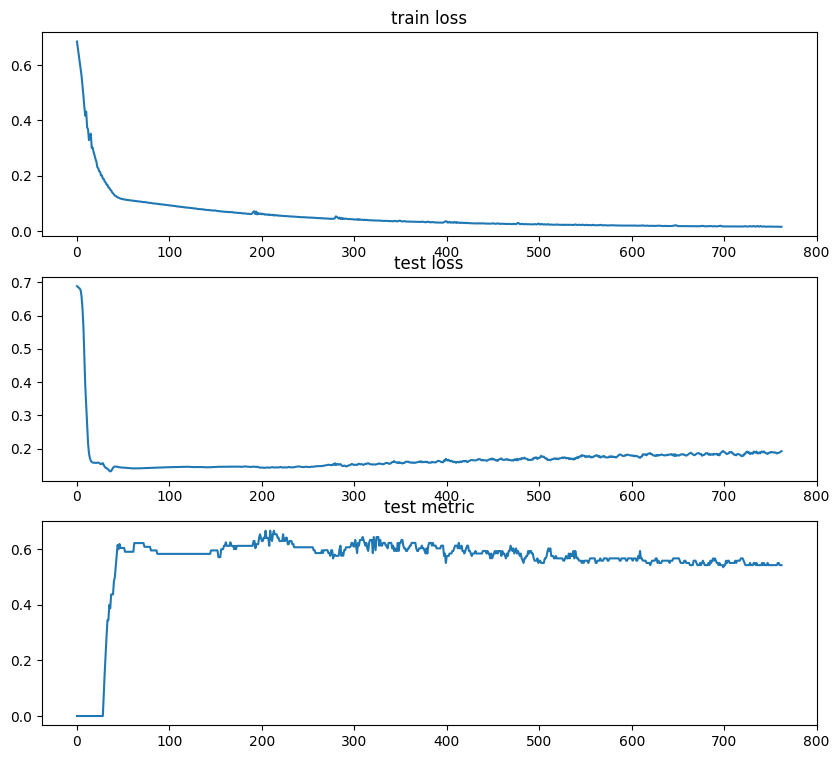

Epoch[763/1000] | loss train:0.015861, test:0.192053


0it [00:00, ?it/s]

In [ ]:
CrossValidationExperement(records, annots, times, all_labels, , 
                          shuffle_leads=False, low_freq=True, is_train=True, area_SWI=True, write_edf=False, model_name="SEED")

100%|███████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 14.49it/s]


7333.14545
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
False


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


<Annotations | 2087 segments: * (43), EndPredictionTime (1), ...>
Overwriting existing file.
Reading 0 ... 2875947  =      0.000 ... 14415.576 secs...


/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 15.79it/s]


4197.47459
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
False
<Annotations | 79 segments: EndPredictionTime (1), ModelPrediction (39), ...>


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


Overwriting existing file.
Reading 0 ... 5512100  =      0.000 ... 27629.194 secs...


/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


12786.44623
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


False
<Annotations | 142 segments: ? (2), EndPredictionTime (1), ModelPrediction ...>
Overwriting existing file.
Reading 0 ... 5789904  =      0.000 ... 29021.676 secs...


/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████| 37/37 [00:02<00:00, 15.55it/s]


4934.58235


IndexError: index 148000 is out of bounds for axis 0 with size 148000

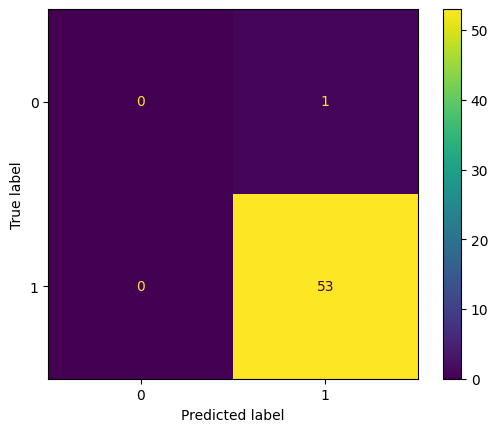

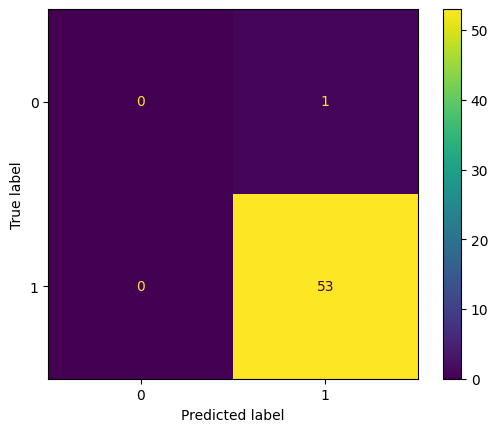

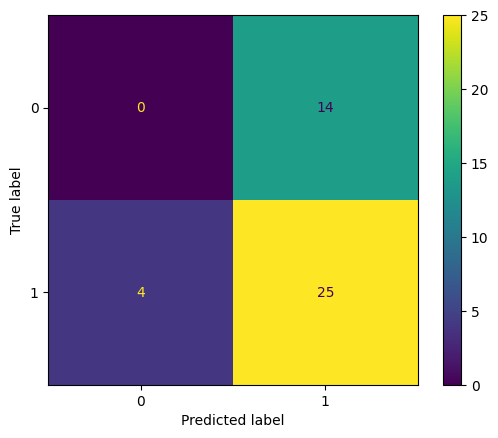

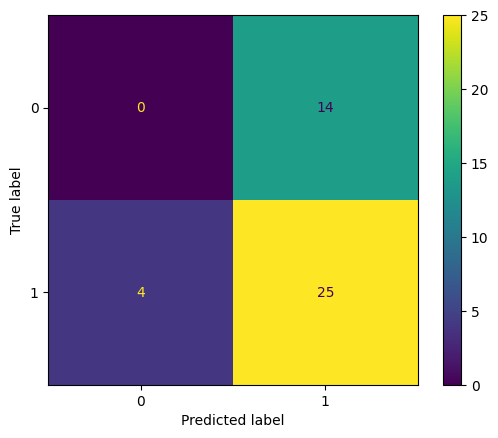

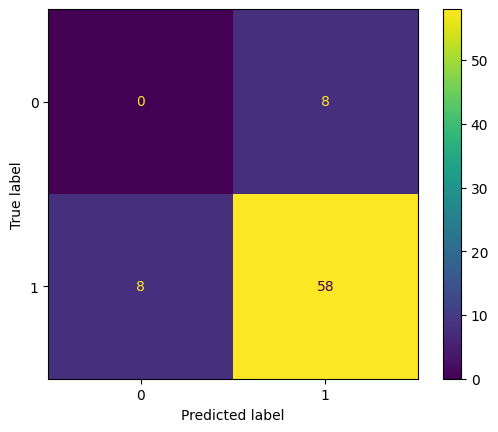

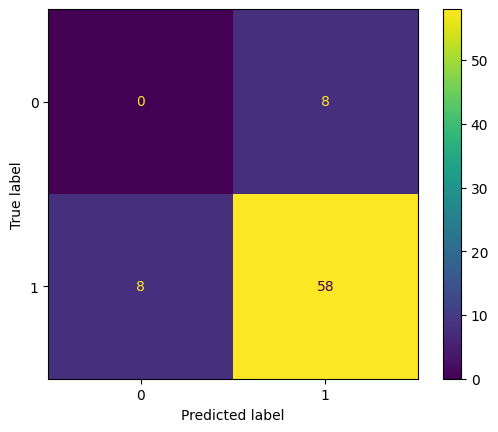

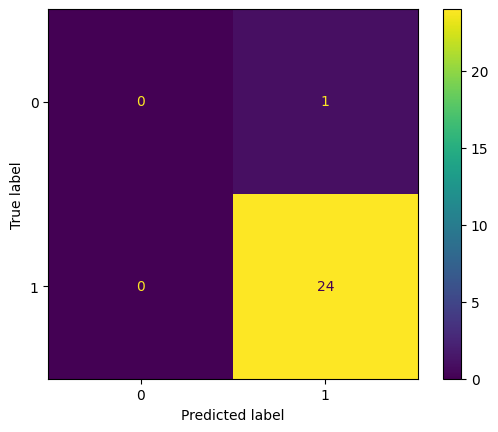

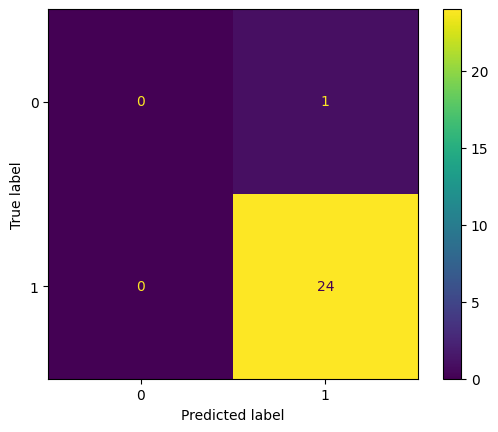

In [52]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/6RecordsMetricOptThs30SEED", 
                          shuffle_leads=False, low_freq=True, is_train=False, area_SWI=True, write_edf=True, model_name="SEED")

100%|███████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 16.32it/s]


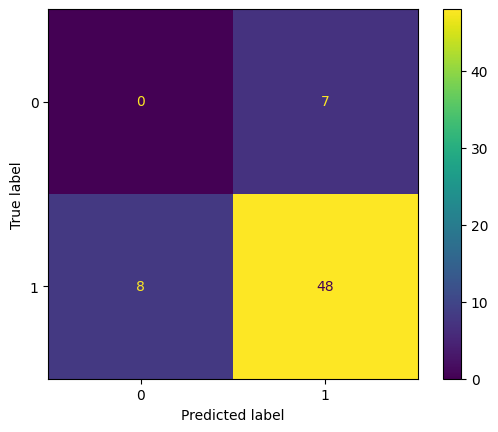

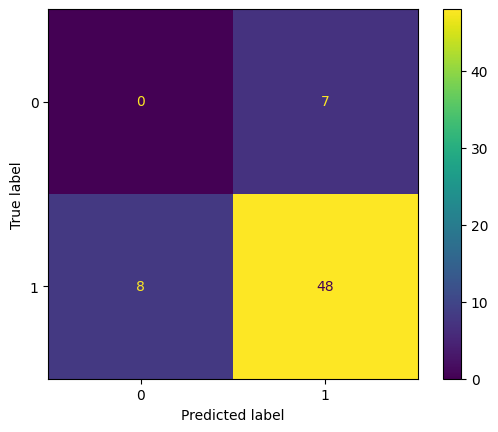

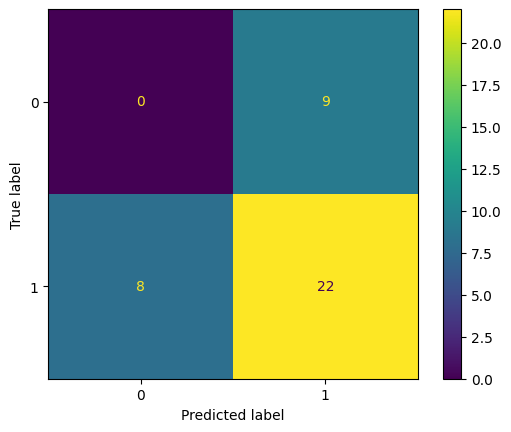

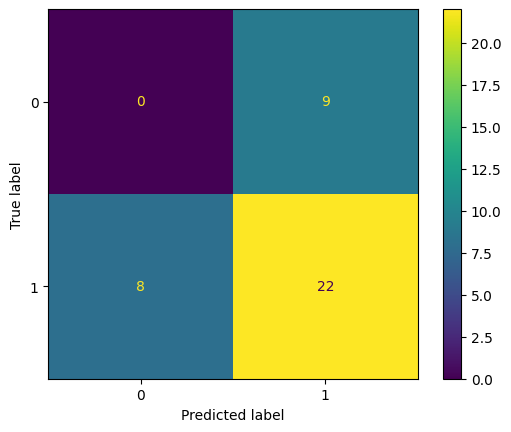

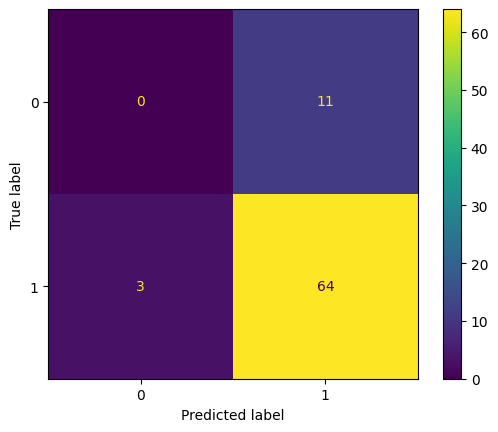

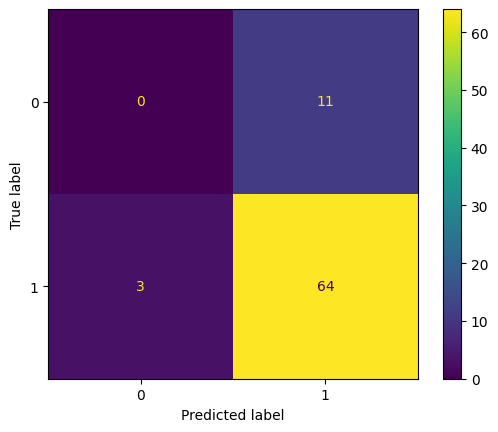

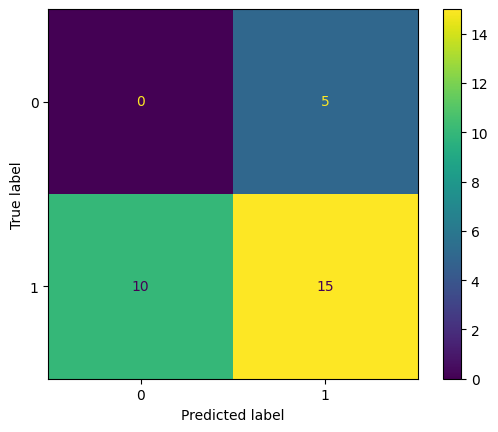

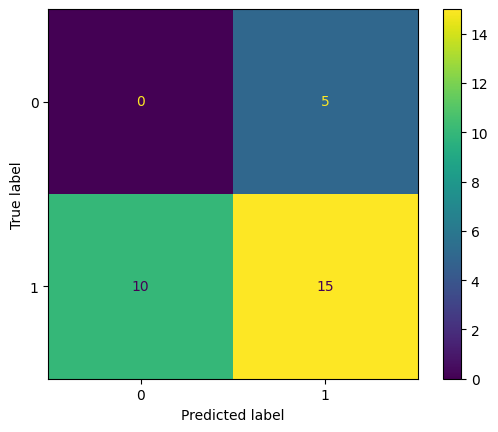

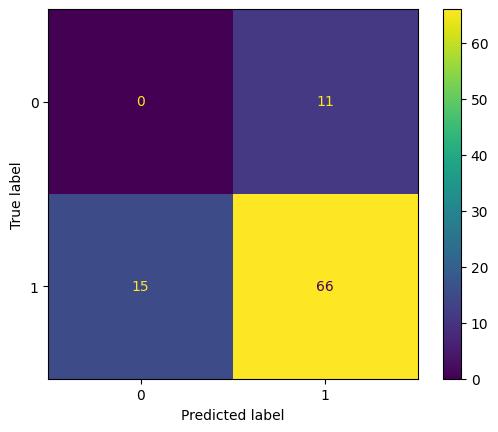

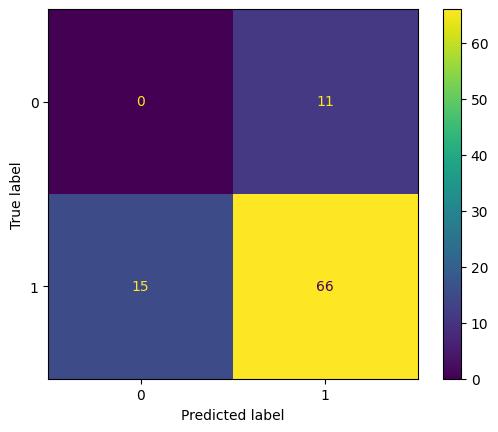

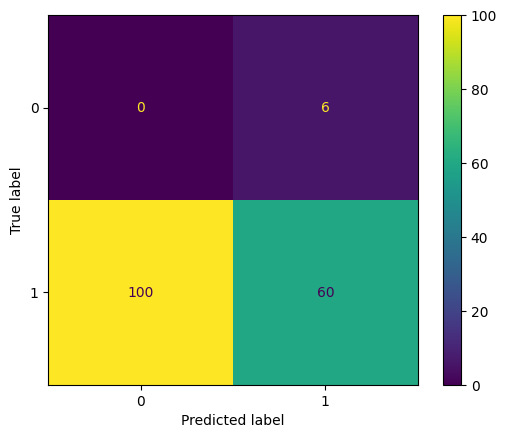

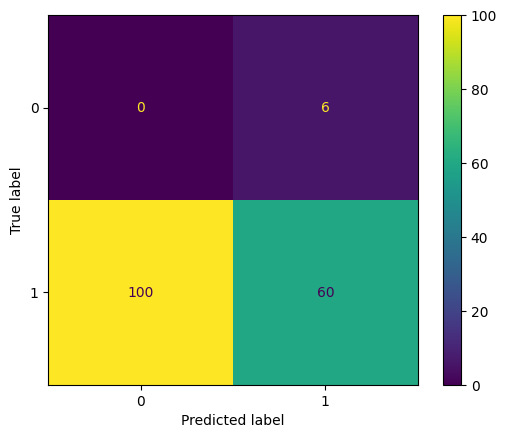

In [58]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/6RecordsMetricOptThs30Normalised", 
                          shuffle_leads=False, low_freq=True, is_train=False, area_SWI=True, write_edf=False)

100%|█████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.36it/s]


7333.14545
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
False


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


<Annotations | 2145 segments: * (43), EndPredictionTime (1), ...>
Reading 0 ... 2875947  =      0.000 ... 14415.576 secs...


/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|█████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.73it/s]


4197.47459
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
False


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


<Annotations | 72 segments: EndPredictionTime (1), ModelPrediction (32), ...>
Reading 0 ... 5512100  =      0.000 ... 27629.194 secs...


/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|█████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.53it/s]


12786.44623
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


False
<Annotations | 144 segments: ? (2), EndPredictionTime (1), ModelPrediction ...>
Reading 0 ... 5789904  =      0.000 ... 29021.676 secs...


/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|█████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.09it/s]


4934.58235
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
False
<Annotations | 60 segments: ? (1), EndPredictionTime (1), ModelPrediction ...>
Reading 0 ... 1489315  =      0.000 ...  7465.135 secs...


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])
/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])
/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|█████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.54it/s]


11978.99091
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
False


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])
/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


<Annotations | 274 segments: ? (20), EndPredictionTime (1), ...>
Reading 0 ... 6785103  =      0.000 ... 34010.073 secs...


/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|█████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.47it/s]


21695.94106
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])
/tmp/ipykernel_2314547/3889916697.py:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


False
<Annotations | 299 segments: ? (29), EndPredictionTime (1), ...>
Reading 0 ... 7345487  =      0.000 ... 36818.977 secs...


/tmp/ipykernel_2314547/3889916697.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


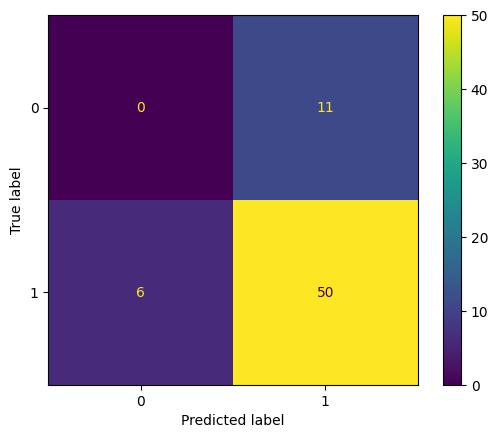

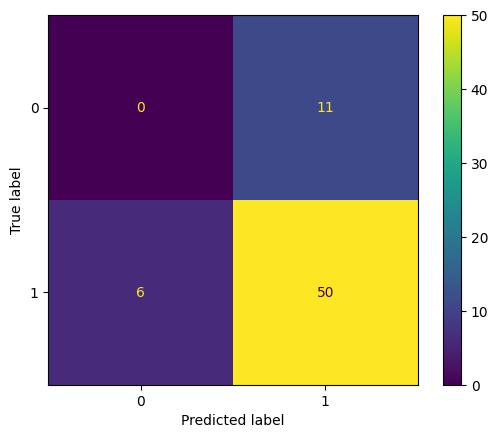

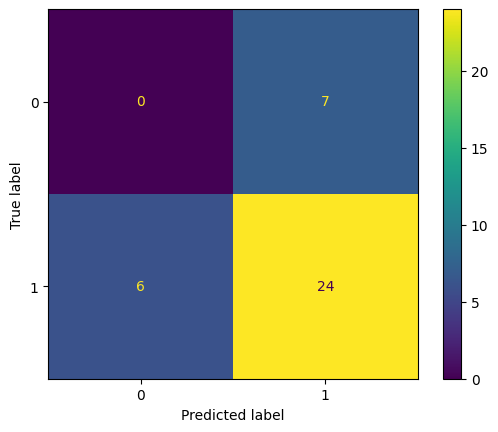

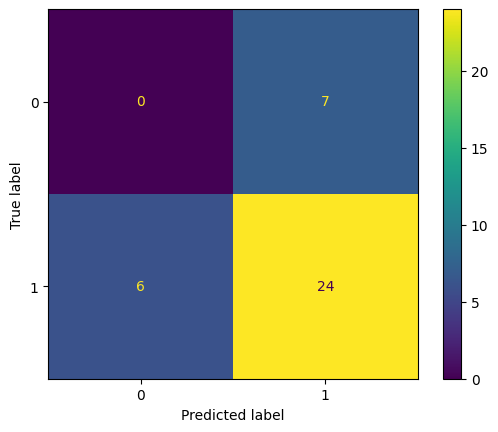

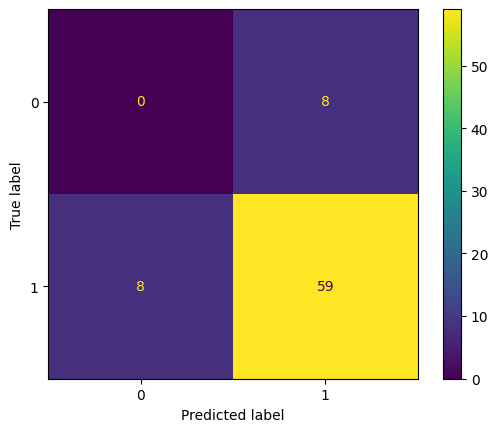

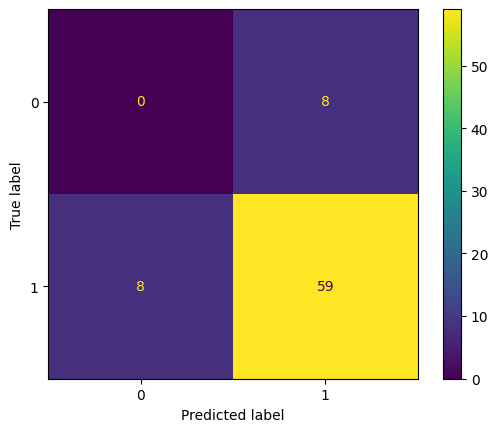

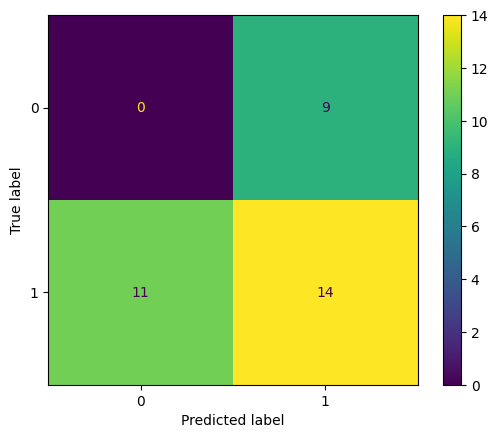

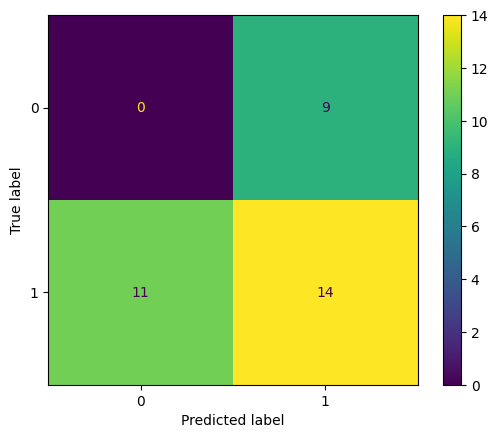

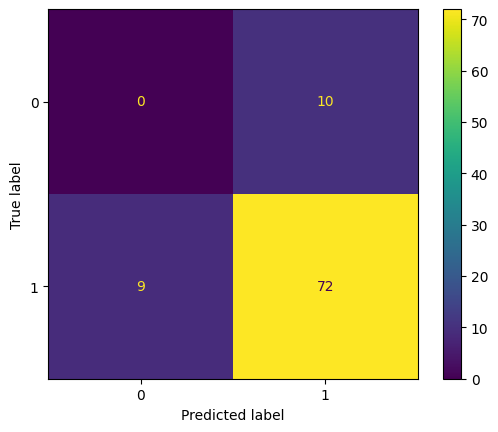

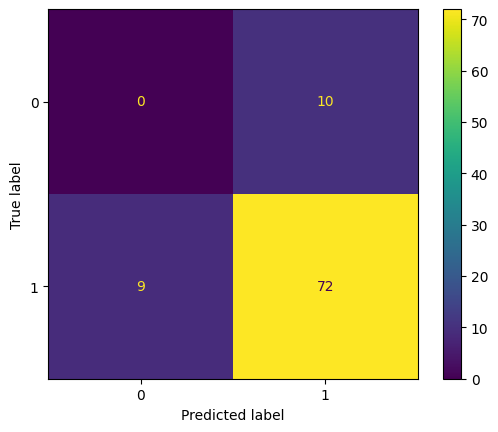

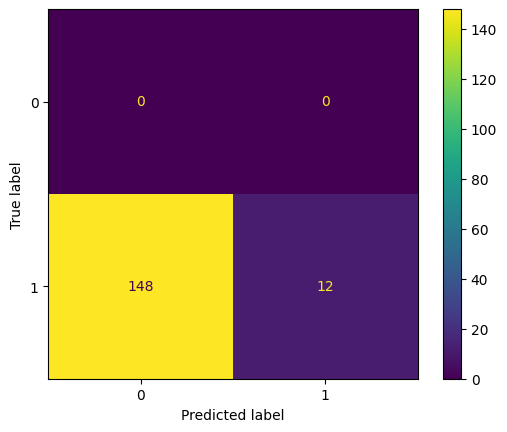

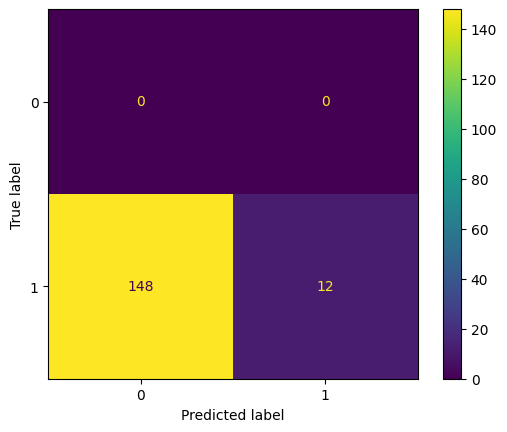

In [60]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/6RecordsMetricOptThs30NormalisedFixedMetric", 
                          shuffle_leads=False, low_freq=True, is_train=False, area_SWI=True, write_edf=True)

100%|███████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.04it/s]


12786.44623
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/Sleep Spindles/MoscowSpecialistsData/P4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_670926/2108154312.py:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(test_record_names[i])


False
<Annotations | 87 segments: EndPredictionTime (1), ModelPrediction (85), ...>
Overwriting existing file.
Reading 0 ... 5789904  =      0.000 ... 29021.676 secs...


/tmp/ipykernel_670926/2108154312.py:28: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


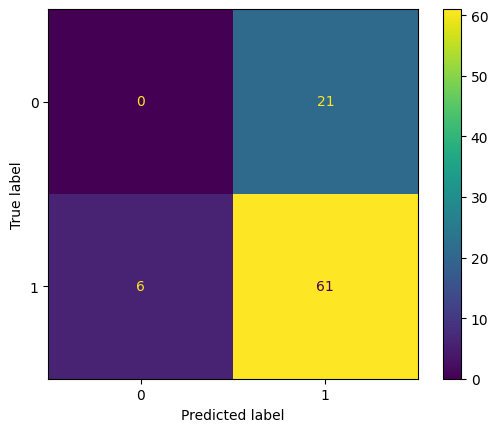

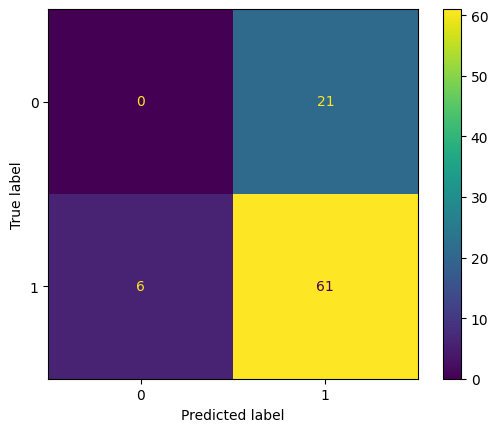

In [46]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/MASSIncludedDiferentSampleRate", 
                          shuffle_leads=False, low_freq=True, is_train=False, area_SWI=True, write_edf=True)

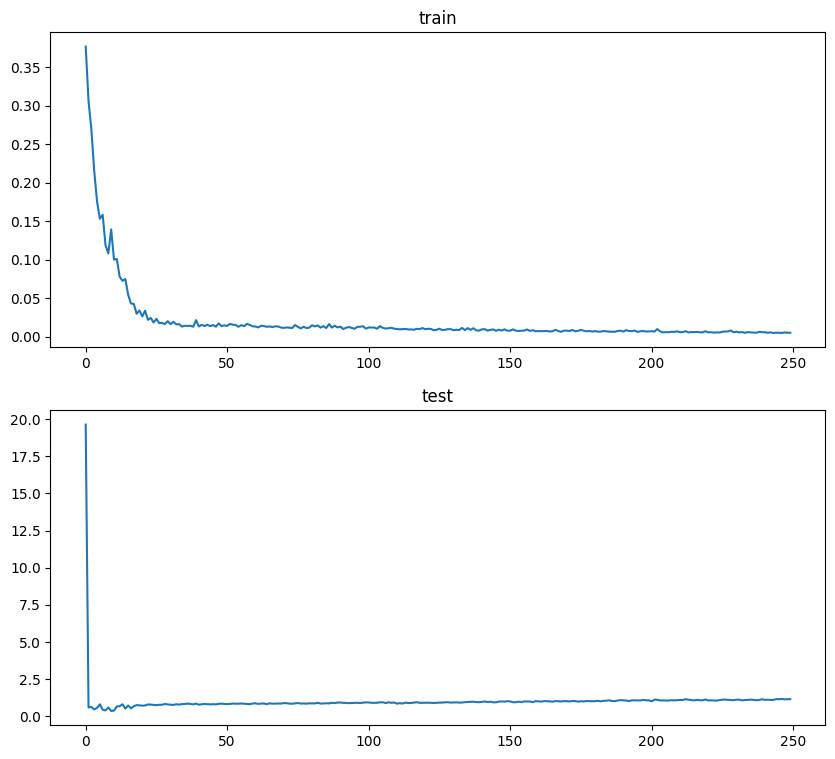

Epoch[250/250] | loss train:0.005294, test:1.151997


100%|████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 16.94it/s]


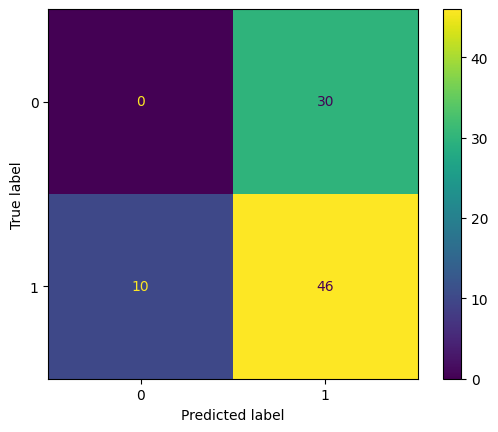

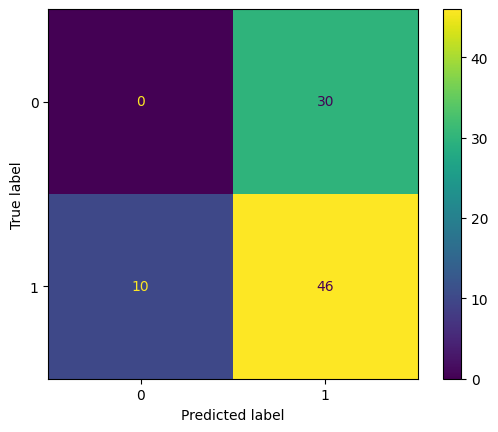

In [20]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/FirstExperement", 
                          shuffle_leads=False, low_freq=True, is_train=True, area_SWI=True)